In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

/home/johanneshj/.pyenv/versions/venv-enrico/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [ ]:
class FreqProxy:
    #This happens when you create (initialize) the class i.e. class = FreqProxy(args,kwargs) somewhere
    def __init__(self, *args, **kwargs) -> None:
        self._freqs = []
        self._lc = None
        self._pg = None
        
        if all(isinstance(a, str) for a in args):
            args = iter(args)
            id = next(args, None)
            cadence = next(args, 'long')

            if 'KIC' in id.upper():
                mission = 'Kepler'
            elif 'TIC' in id.upper():
                mission = 'TESS'

            search_results = lk.search_lightcurve(target=f'{id}', mission=f'{mission}', cadence=f'{cadence}')
            if len(search_results) == 0:
                raise ValueError(f"No light curves found for {id} ({mission}).")
            
            data_per_author = {author: np.sum(search_results.author == author)
                               for author in np.unique(search_results.author)
                               }
            author = max(data_per_author, key=data_per_author.get)

            lc = search_results(author=author).download_all().stitch()
            self._lc, self._pg = self.data_prep(lc)
        elif any(isinstance(a, (list, np.ndarray)) for a in args):
            arrays = [np.array(a) for a in args if isinstance(a, (list, np.ndarray))]
            strings = [a for a in args if isinstance(a, str)]
            id = strings[0] if strings else None

            arrays = iter(arrays)
            time = next(arrays, None)
            flux = next(arrays, None)
            if time is None or flux is None:
                raise ValueError("Must provide at least time and flux arrays.")
            flux_err = next(arrays, None)

            lc = lk.LightCurve(time=time, flux=flux, flux_err=flux_err)
            self._lc, self._pg = self.data_prep(lc)
        elif len(args) < 1:
            search_results = lk.search_lightcurve('KIC 12008916', 
                                                  mission='Kepler', 
                                                  cadence='long', 
                                                  quarter=np.arange(0,60))
            lc = search_results(author=author).download_all().stitch()
            self._lc, self._pg = self.data_prep(lc)
    

        
    #This happens when you call it i.e. class(args,kwargs)
    def __call__(self,*args, **kwargs) -> dict:
        
        self.proxies(args)

        mean = np.mean(self.freqs)
        var = np.var(self.freqs,ddof=1)
        return  {"freqs":self.freqs,"mean":mean,"var":var}

    #This is called a decorator :D
    # _ in front of a variable makes it "hidden"
    #you call this as class.freqs
    @property
    def freqs(self):
        return self._freqs
   
    # This decorator removes access to environment variable (don't think it'll need it and it's C L E A N)
    @staticmethod
    def ACF(pg):
        "Calculates Autocorrelation"
        #Integral whatever goes here

        frequency = pg.frequency.value
        power = pg.power.value
        
        var = np.var(spec, ddof=1)
        mean = np.mean(spec)
        

        def iprod(x,y):
            "Calculates inner-product"
            return np.sqrt(np.sum(x*y))
        prod = iprod(spec,spec)
        return None
    
    @staticmethod
    def data_prep(lc):
        '''
            Prepare data:
            lc :: lightkurve LC object
        '''
        if hasattr(lc, "stitch"):
            lc = lc.stitch().remove_nans().remove_outliers(5)
        else:
            lc = lc.remove_nans().remove_outliers(5)
        flux = (lc.flux - 1)*1e6
        time = lc.time.value - lc.time.value[0]

        gap_indices = np.concatenate((np.where(np.diff(time) > 3)[0], [len(time)-1]))
        gap = 0
        for i in range(1, len(gap_indices)):
            start = gap_indices[i-1]+1
            end = gap_indices[i]
            gap = (time[start]-time[start-1]) - 3
            time[start:end+1] -= gap
        
        lc = lk.LightCurve(time=time, flux=flux, flux_err=lc.flux_err)
        pg = lc.to_periodogram(freq_unit='uHz', normalization='psd')
        return lc, pg
                    
    def calculate_relative_power(frequency, power):

        nbins = 0
        bins = np.logspace(np.log10(min(frequency)), 
                        np.log10(max(frequency)), 
                        0,
                        endpoint=False
                        )
        indices = np.digitize(frequency, bins, right=False) 

        binned_freq = [frequency[np.where(indices==idx)[0]] for idx in np.unique(indices)] # bin the frequencies
        binned_power = [power[np.where(indices==idx)[0]] for idx in np.unique(indices)] # bin the powers

        bin_centers = [(freq_bin[-1] - freq_bin[0]) / 2 for freq_bin in binned_freq] # find bin centers
        df = np.mean(np.diff(frequency)) # find resolution
        if np.max(frequency) > 300:
            ws = 100 # muHz
        else:
            ws = 10 # muHz
        wls = np.ones_like(bin_centers, dtype=int) * (int(ws/df)) # calculate window sizes for median filter (100 muHz Viani 2019)
        # wls = [int(max(100/df, (2/3)*bin_center**(22/25)/df)) for bin_center in bin_centers] # alternative window size calculation
        wls = [wl if wl % 2 != 0 else wl + 1 for wl in wls] # make sure window sizes are odd

        filter = np.concatenate([median_filter(power_bin, wl, mode='reflect') for power_bin, wl in zip(binned_power, wls)])
        rel_power = (power - filter)/filter
        return rel_power

    # Pretty sure it can be prettier :v
    def proxies(self,args):
        funcs = [member.__func__ for member in vars(FreqProxy).values() if isinstance(member, staticmethod)]
        for func in funcs:
          self._freqs.append(func(args))

        #Previous shit should do the same as this
        self._freqs.append(self.ACF(args))
        self._freqs.append(self.ACFtwod(args))
        self._freqs.append(self.fliper(args))
        self._freqs.append(self.Scalingrel(args))
        self._freqs.append(self.Varcoeff(args))

In [63]:
search_results = lk.search_lightcurve('KIC 12008916', mission='Kepler', cadence='long', quarter=np.arange(0,60))
search_results

SearchResult containing 18 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 00 2009 Kepler    1800 kplr012008916      0.0
  1 Kepler Quarter 01 2009 Kepler    1800 kplr012008916      0.0
  2 Kepler Quarter 02 2009 Kepler    1800 kplr012008916      0.0
  3 Kepler Quarter 03 2009 Kepler    1800 kplr012008916      0.0
  4 Kepler Quarter 04 2010 Kepler    1800 kplr012008916      0.0
  5 Kepler Quarter 05 2010 Kepler    1800 kplr012008916      0.0
  6 Kepler Quarter 06 2010 Kepler    1800 kplr012008916      0.0
  7 Kepler Quarter 07 2010 Kepler    1800 kplr012008916      0.0
  8 Kepler Quarter 10 2011 Kepler    1800 kplr012008916      0.0
  9 Kepler Quarter 08 2011 Kepler    1800 kplr012008916      0.0
 10 Kepler Quarter 09 2011 Kepler    1800 kplr012008916      0.0
 11 Kepler Quarter 11 2012 Kepler    1800 kplr012008916      0.0
 12 Kepler Quarter 12 2012 Kepler    1800 kplr012008916      0.0
 13 Kepler Quarter 13 2012 Kepler    1800 kplr012008916      0.0
 14 Kepler Quarter 14 2012 Kepler    1800 kplr012008916      0.0
 15 Kepler Quarter 16 2013 Kepler    1800 kplr012008916      0.0
 16 Kepler Quarter 15 2013 Kepler    1800 kplr012008916      0.0
 17 Kepler Quarter 17 2013 Kepler    1800 kplr012008916      0.0

[31825 59610]


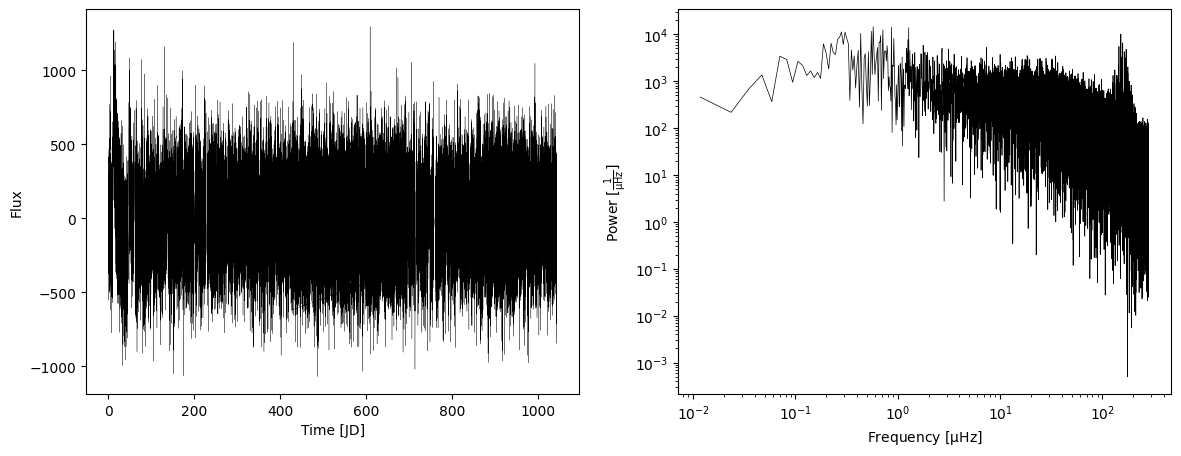

65262


In [64]:
lc = search_results.download_all()
lc = lc.stitch().remove_nans().remove_outliers(5)
flux = (lc.flux - 1)*1e6

time = lc.time.value
time -= time[0]
gap_indices = np.concatenate((np.where(np.diff(time) > 3)[0], [len(time)-1]))
#gap_indices = np.where(np.diff(time) > 3)[0]
#print(gap_indices)
gap = 0
for i in range(1, len(gap_indices)):
    start = gap_indices[i-1]+1
    end = gap_indices[i]
    gap = (time[start]-time[start-1]) - 3
    time[start:end+1] -= gap

print(np.where(np.diff(time)<0)[0])

lc = lk.LightCurve(time=time, flux=flux, flux_err=lc.flux_err)
pg = lc.to_periodogram(freq_unit='uHz', normalization='psd')

fig, axs = plt.subplots(1,2,figsize=(14,5))
lc.plot(ax=axs[0], c='k', lw=0.2)
# for i in range(1, len(gap_indices)):
#     start = gap_indices[i-1]+1
#     end = gap_indices[i]
#     axs[0].axvline(time[start])
#     axs[0].axvline(time[end], c='r')
pg.plot(ax=axs[1], c='k', scale='log')
plt.show()
print(len(lc.time))

np.savetxt('rg_lc.txt', 
           np.column_stack((np.asarray(lc.time.value), 
                            np.asarray(lc.flux.value), 
                            np.asarray(lc.flux_err.value))), 
           header='time flux err')

np.savetxt('rg_pg.txt', 
           np.column_stack((np.asarray(pg.frequency.value), np.asarray(pg.power.value))), 
           header='frequency power')


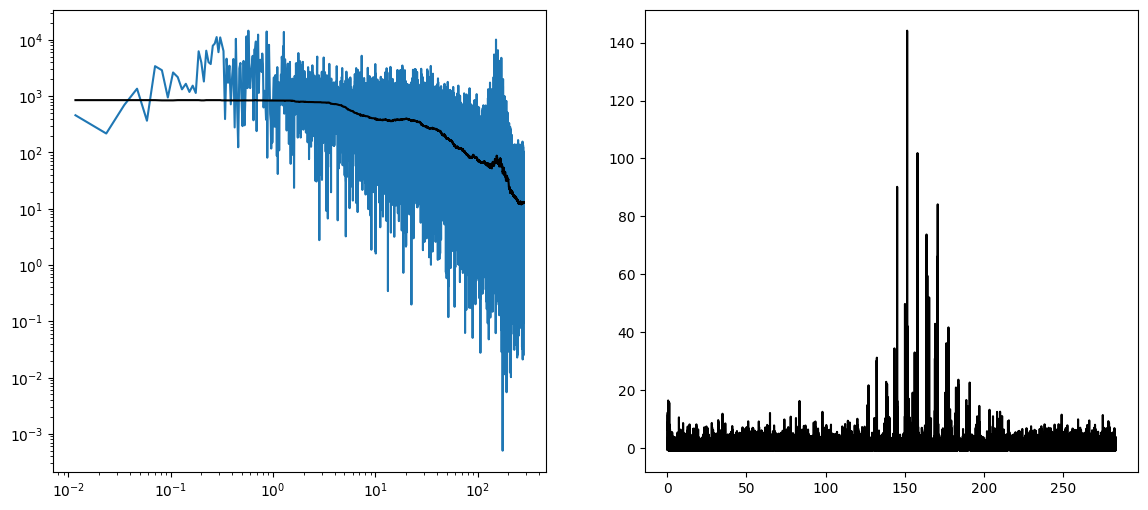

In [ ]:
from scipy.ndimage import median_filter

data = np.loadtxt('ms_lc.txt', comments='#', usecols=(0,1,2))
time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]

lc = lk.LightCurve(time=time, flux=flux, flux_err=flux_err)
pg = lc.to_periodogram(freq_unit='uHz', normalization='psd')

frequency = pg.frequency.value
power = pg.power.value
def calculate_relative_power(frequency, power, plot=False):
    frequency = pg.frequency.value
    power = pg.power.value

    nbins = 0
    bins = np.logspace(np.log10(min(frequency)), 
                    np.log10(max(frequency)), 
                    0,
                    endpoint=False
                    )
    indices = np.digitize(frequency, bins, right=False) 

    binned_freq = [frequency[np.where(indices==idx)[0]] for idx in np.unique(indices)] # bin the frequencies
    binned_power = [power[np.where(indices==idx)[0]] for idx in np.unique(indices)] # bin the powers

    bin_centers = [(freq_bin[-1] - freq_bin[0]) / 2 for freq_bin in binned_freq] # find bin centers
    df = np.mean(np.diff(frequency)) # find resolution
    if np.max(frequency) > 300:
        ws = 100 # muHz
    else:
        ws = 10 # muHz
    wls = np.ones_like(bin_centers, dtype=int) * (int(ws/df)) # calculate window sizes for median filter (100 muHz Viani 2019)
    # wls = [int(max(100/df, (2/3)*bin_center**(22/25)/df)) for bin_center in bin_centers] # alternative window size calculation
    wls = [wl if wl % 2 != 0 else wl + 1 for wl in wls] # make sure window sizes are odd

    filter = np.concatenate([median_filter(power_bin, wl, mode='reflect') for power_bin, wl in zip(binned_power, wls)])
    rel_power = (power - filter)/filter

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(14,6))
        for freq_bin, power_bin in zip(binned_freq, binned_power):
            axs[0].loglog(freq_bin, power_bin)
        axs[0].loglog(frequency, filter, c='k')
        axs[1].plot(frequency, rel_power, c='k', alpha=1.0)
        plt.show()

    return rel_power 

rel_power = calculate_relative_power(frequency, power, plot=True)

(24, 4260)
LC ACF time: 0.04959297180175781 seconds
(24, 4260)


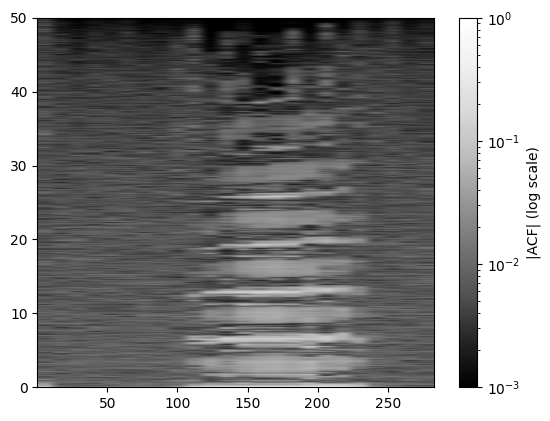

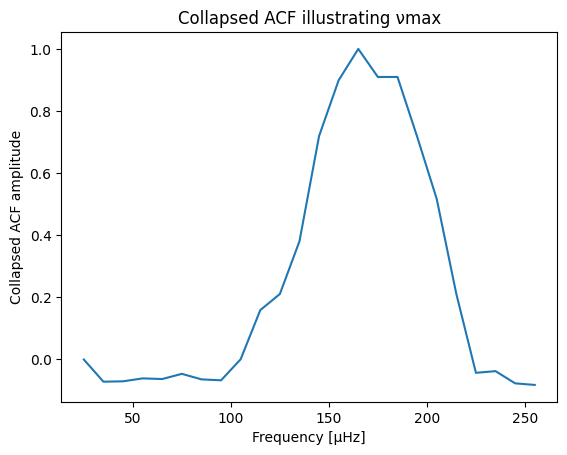

In [66]:
from numpy.lib.stride_tricks import sliding_window_view
from matplotlib.colors import LogNorm
from scipy.signal import correlate2d
from numba import njit
import seaborn as sns
import time
import pyfftw

def two_dim_ACF(frequency, power, plot=False):
    df = np.mean(np.diff(frequency))

    if np.max(frequency) > 300:
        window_size_muHz = 250   # desired window width
        overlap_muHz = 249      # desired overlap
        window_size = int(window_size_muHz / df)
        step = int((window_size_muHz - overlap_muHz) / df)
        freq_windows = sliding_window_view(frequency, window_shape=window_size)[::step]
        power_windows = sliding_window_view(power, window_shape=window_size)[::step].copy()
        print(freq_windows.shape)
    else:
        window_size_muHz = 50   # desired window width
        overlap_muHz = 40    # desired overlap
        window_size = int(window_size_muHz / df)
        step = int((window_size_muHz - overlap_muHz) / df)
        freq_windows = sliding_window_view(frequency, window_shape=window_size)[::step]
        power_windows = sliding_window_view(power, window_shape=window_size)[::step].copy()
        print(freq_windows.shape)
    
    def batch_fft_acf(power_windows):
        _, n_points = power_windows.shape
        nfft = 1 << (2 * n_points - 1).bit_length()
        power_windows -= np.mean(power_windows, axis=1, keepdims=True)

        start = time.time()
        fft = np.fft.rfft(power_windows, n=nfft, axis=1)
        end = time.time()
        print(f"FFT computation time: {end - start:.4f} seconds")

        start = time.time()
        psd = np.abs(fft)**2
        end = time.time()
        print(f"PSD computation time: {end - start:.4f} seconds")

        start = time.time()
        acf = np.fft.irfft(psd, n=nfft, axis=1)
        end = time.time()
        print(f"Inverse FFT computation time: {end - start:.4f} seconds")

        start = time.time()
        acf = acf[:, :n_points]
        end = time.time()
        print(f"Lags time: {end - start:.4f} seconds")

        start = time.time()
        acf /= np.max(acf, axis=1, keepdims=True)
        end = time.time()
        print(f"Norm time: {end - start:.4f} seconds")

        return abs(acf)
    
    def abs_acf(x):
        x = x - np.mean(x)
        corr = np.correlate(x, x, mode='full')
        corr = corr[corr.size // 2:] # grab only the positive lags
        return np.abs(corr / np.max(corr))
    
    #if df < 
    #acfs = batch_fft_acf(power_windows)
    if np.max(frequency) > 300:
        acfs = batch_fft_acf(power_windows)
    else:
        start = time.time()
        acfs = np.array([abs_acf(seg) for seg in power_windows]) #
        end = time.time()
        print('LC ACF time:', end-start, 'seconds')
        
    print(acfs.shape)    
    
    if plot:
        plt.figure()
        plt.imshow(acfs.T,
                   cmap='Greys_r',
                   aspect='auto',
                   norm=LogNorm(vmin=0.001, vmax=1),
                   origin='lower',
                   extent=(frequency[0], frequency[-1], 
                           0, window_size_muHz)
                    )
                   

        # plt.xlabel("Frequency [μHz]")
        # plt.ylabel("Spacing [μHz] (basically lag in frequency)")
        plt.colorbar(label='|ACF| (log scale)')
    
    collapsed_acf_numax = np.mean(acfs, axis=1)
    collapsed_acf_numax = (collapsed_acf_numax - np.median(collapsed_acf_numax))
    collapsed_acf_numax /= np.max(collapsed_acf_numax)
    freq_centers = np.median(freq_windows, axis=1)
    if plot:
        plt.figure()
        plt.plot(freq_centers, collapsed_acf_numax)
        plt.xlabel("Frequency [μHz]")
        plt.ylabel("Collapsed ACF amplitude")
        plt.title("Collapsed ACF illustrating νmax")

two_dim_ACF(frequency, rel_power, plot=True)



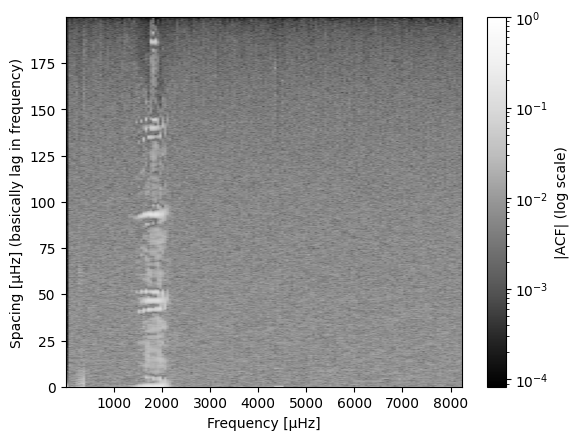

In [201]:
from matplotlib.colors import LogNorm

def abs_acf(x):
    x = x - np.mean(x)
    corr = np.correlate(x, x, mode='full')
    corr = corr[corr.size // 2:] # grab only the positive lags
    return np.abs(corr / np.max(corr))

power_windows = power_windows_og
freq_windows = freq_windows_og

power_windows = power_windows - np.mean(power_windows, axis=1, keepdims=True) # subtract mean power of each segment

acfs = np.array([abs_acf(seg) for seg in power_windows]) # calculate acfs for each segment

lags = np.arange(acfs.shape[1]) * df 
# mask = (lags < 1000)
# lags = lags[mask]
# acfs = acfs[:, mask]

plt.figure()
plt.imshow(
    acfs.T, 
    origin='lower',
    aspect='auto',
    extent=[
        freq_windows[:, 0].min(),
        freq_windows[:, 0].max(),
        lags.min(),
        lags.max()
    ],
    norm=LogNorm(vmin=np.percentile(acfs, 1), vmax=np.max(acfs)),  
    cmap='Grays_r'
)

plt.xlabel("Frequency [μHz]")
plt.ylabel("Spacing [μHz] (basically lag in frequency)")
plt.colorbar(label='|ACF| (log scale)')

Text(0.5, 1.0, 'Collapsed ACF illustrating νmax')

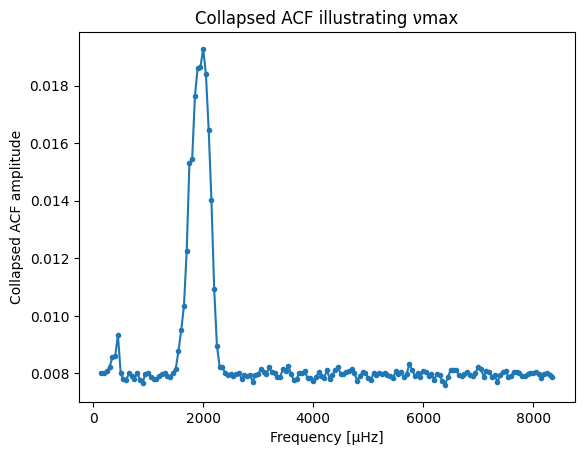

In [217]:
collapsed_acf_numax = np.mean(acfs, axis=1)


freq_centers = np.median(freq_windows, axis=1)

plt.figure()
plt.plot(freq_centers[1:], collapsed_acf_numax[1:], marker='.')
plt.xlabel("Frequency [μHz]")
plt.ylabel("Collapsed ACF amplitude")
plt.title("Collapsed ACF illustrating νmax")


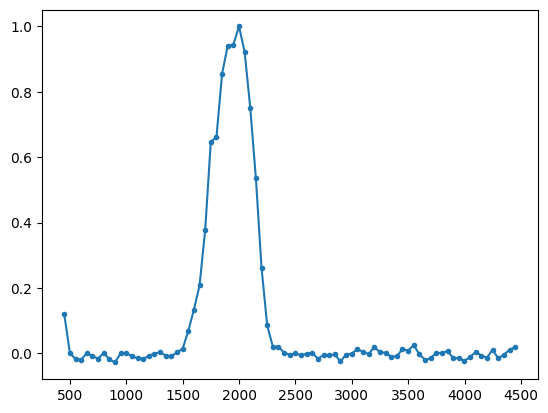

[1.02850916e+00 1.67412436e+02 1.94397465e+03]
[[ 3.02189558e-04 -3.27924369e-02  5.67924183e-09]
 [-3.27924369e-02  1.06755239e+01 -9.24152980e-07]
 [ 5.67924183e-09 -9.24152980e-07  1.06755240e+01]]


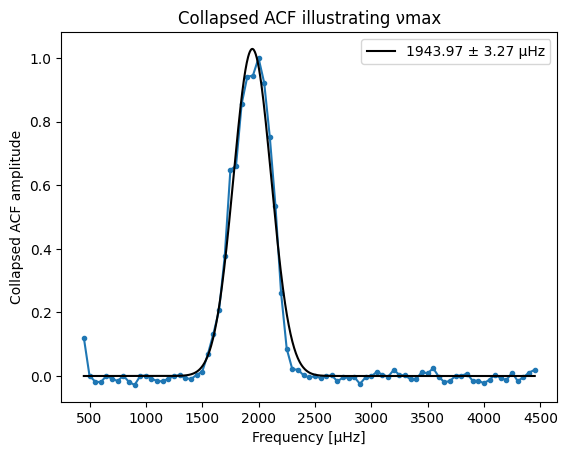

In [234]:
idx_max = np.argmax(collapsed_acf_numax[1:])
numax = freq_centers[idx_max]

# normalize to range [0,1]

collapsed_acf_numax = (collapsed_acf_numax - np.median(collapsed_acf_numax))
collapsed_acf_numax /= np.max(collapsed_acf_numax)

mask = (freq_centers > numax - 1500 ) & (freq_centers < numax + 2500)
plt.plot(freq_centers[mask], collapsed_acf_numax[mask], marker='.')
plt.show()

from scipy.optimize import curve_fit

def gaussian(x, A, sigma, mu):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

popt, pcov = curve_fit(gaussian, freq_centers[mask], collapsed_acf_numax[mask], p0=[1, (2/3)*numax**(22/25), numax])
print(popt)
print(pcov)
x = np.linspace(numax - 1500, numax + 2500, 1000)
plt.plot(freq_centers[mask], collapsed_acf_numax[mask], marker='.')
plt.plot(x, gaussian(x, *popt), c='k', ls='-', label=f'{popt[2]:.2f} ± {np.sqrt(pcov[2,2]):.2f} μHz')
plt.legend()
plt.xlabel("Frequency [μHz]")
plt.ylabel("Collapsed ACF amplitude")
plt.title("Collapsed ACF illustrating νmax")
plt.show()